# MNIST CNN model

In [3]:
# copied from: https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/

# baseline cnn model for mnist
from numpy import mean
from numpy import std
import numpy as np
import pandas as pd
from matplotlib import pyplot
import tensorflow as tf
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split


# load train and test dataset
def load_dataset(testsize=0.03):
	# load dataset
	(trainX, trainY), (testX, testY) = mnist.load_data()
	X = np.concatenate((trainX, testX), axis=0)
	Y = np.concatenate((trainY, testY), axis=0)
    
	# Over sampling the data where there are lesser coutns 
	val = pd.DataFrame(Y).value_counts()
	#MAX_SAMPLES = max(val)
	MAX_SAMPLES = 9000
	indexes = sorted([x[0] for x in val.index])
	idx = np.random.choice(np.where(Y==indexes[0])[0],size=MAX_SAMPLES,replace=True)
	X1 = X[idx,:,:]
	Y1=  Y[idx]
	for indx in indexes[1:]:
		#print(indx)
		idx = np.random.choice(np.where(Y==indx)[0],size=MAX_SAMPLES,replace=True)
		X1 = np.concatenate((X[idx,:,:], X1), axis=0)
		Y1 = np.concatenate((Y[idx], Y1), axis=0)
    
    
    
    
	trainX, testX, trainY, testY = train_test_split(X1, Y1, test_size=testsize)
	print(trainX.shape, testX.shape, trainY.shape, testY.shape)
	# reshape dataset to have a single channel
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

# define cnn model (advanced model)
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(learning_rate=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories

# plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		pyplot.subplot(2, 1, 1)
		pyplot.title('Cross Entropy Loss')
		pyplot.plot(histories[i].history['loss'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		pyplot.subplot(2, 1, 2)
		pyplot.title('Classification Accuracy')
		pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	pyplot.show()

# summarize model performance
def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	# box and whisker plots of results
	pyplot.boxplot(scores)
	pyplot.show()

# run the test harness for evaluating a model
def run_test_harness(epoches=4):
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # define model
    model = define_model()
    # fit model
    model.fit(trainX, trainY, epochs=epoches, batch_size=32, verbose=1)
    # save model
    print("Saving the model")
    model.save('final_model.h5')
    # load model
    #model = load_model('final_model.h5')
    # evaluate model on test dataset
    _ ,acc = model.evaluate(testX, testY, verbose=0)
    print('> %.3f' % (acc * 100.0))

(87300, 28, 28) (2700, 28, 28) (87300,) (2700,)
> 99.696
> 99.576
> 99.737
> 99.639
> 99.656


<ipython-input-3-81e016cc34e0>:108: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  pyplot.subplot(2, 1, 1)
<ipython-input-3-81e016cc34e0>:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  pyplot.subplot(2, 1, 2)


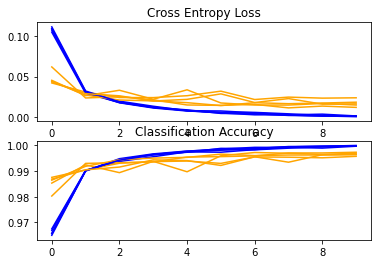

Accuracy: mean=99.661 std=0.054, n=5


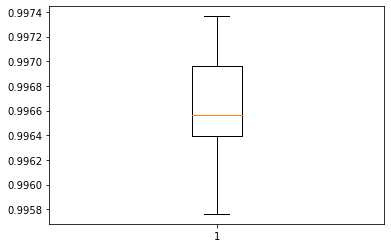

In [4]:
# run the test harness for evaluating a model
def run_test_harness1():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# evaluate model
	scores, histories = evaluate_model(trainX, trainY)
	# learning curves
	summarize_diagnostics(histories)
	# summarize estimated performance
	summarize_performance(scores)
 
# entry point, run the test harness
run_test_harness1()

In [5]:
# run the test harness for evaluating a model
def run_test_harness(epoches=4):
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # define model
    model = define_model()
    # fit model
    model.fit(trainX, trainY, epochs=epoches, batch_size=32, verbose=1)
    # save model
    print("Saving the model")
    model.save('final_model.h5')
    # load model
    #model = load_model('final_model.h5')
    # evaluate model on test dataset
    _ ,acc = model.evaluate(testX, testY, verbose=0)
    print('> %.3f' % (acc * 100.0))

# entry point, run the test harness
run_test_harness()

(87300, 28, 28) (2700, 28, 28) (87300,) (2700,)
Epoch 1/4
2729/2729 [==============================] - 61s 22ms/step - loss: 0.0933 - accuracy: 0.9707
Epoch 2/4
2729/2729 [==============================] - 59s 22ms/step - loss: 0.0280 - accuracy: 0.9913
Epoch 3/4
2729/2729 [==============================] - 59s 21ms/step - loss: 0.0154 - accuracy: 0.9953
Epoch 4/4
2729/2729 [==============================] - 61s 22ms/step - loss: 0.0091 - accuracy: 0.9973
Saving the model
> 99.778


In [17]:
# copied from: https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/
#model = tf.load_model('final_model.h5')

In [84]:
new_model = tf.keras.models.load_model('final_model.h5')

# Check its architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               1

In [85]:
# make a prediction for a new image.
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
 
# load and prepare the image
def load_image(filename):
	# load the image
	img = load_img(filename, grayscale=True, target_size=(28, 28))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 1 channel
	img = img.reshape(1, 28, 28, 1)
	# prepare pixel data
	img = img.astype('float32')
	img = img / 255.0
	return img
 
# load an image and predict the class
def run_example(file_name):
	# load the image
	img = load_image(file_name)
	# load model
	model = load_model('final_model.h5')
	# predict the class
	digit = new_model.predict_classes(img)
	# print(digit)
	print("The prediction for %s this value is : %s"%(file_name,digit[0]))
 

In [86]:
import os
os.listdir("./test_images_mnist")

['1.png', '12.png', '2.png', '4.png', '7.png']

In [87]:
for fln in os.listdir("./test_images_mnist"):
    run_example("./test_images_mnist/"+fln)

C:\Users\91990\anaconda3\envs\pyocv\lib\site-packages\keras_preprocessing\image\utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\91990\anaconda3\envs\pyocv\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


The prediction for ./test_images_mnist/1.png this value is : 4
The prediction for ./test_images_mnist/12.png this value is : 4
The prediction for ./test_images_mnist/2.png this value is : 0
The prediction for ./test_images_mnist/4.png this value is : 4
The prediction for ./test_images_mnist/7.png this value is : 4


In [5]:
import numpy as np
(trainX, trainY), (testX, testY) = mnist.load_data()

In [6]:
X = np.concatenate((trainX, testX), axis=0)
Y = np.concatenate((trainY, testY), axis=0)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.03)
print(trainX.shape, testX.shape, trainY.shape, testY.shape)

(67900, 28, 28) (2100, 28, 28) (67900,) (2100,)


In [39]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.03)
print(trainX.shape, testX.shape, trainY.shape, testY.shape)

(67900, 28, 28) (2100, 28, 28) (67900,) (2100,)


In [37]:
X[np.random.choice(np.where(Y==0)[0],100),:,:].shape

(100, 28, 28)

In [35]:
np.where(Y==0)[0]

array([    1,    21,    34, ..., 69964, 69983, 69993], dtype=int64)

In [43]:
idx = np.random.choice(np.where(Y==0)[0],n=100,replace=True)

TypeError: choice() got an unexpected keyword argument 'n'

In [57]:
Counter(Y).values

<function Counter.values>

In [54]:
for x in Counter(Y).keys:
    print(x)

TypeError: 'builtin_function_or_method' object is not iterable

In [44]:
from collections import Counter

In [80]:
pd.Series(Counter(Y1))

9    7877
8    7877
7    7877
6    7877
5    7877
4    7877
3    7877
2    7877
1    7877
0    7877
dtype: int64

In [41]:
import pandas as pd
val = pd.DataFrame(Y).value_counts()
MAX_SAMPLES = max(val)
indexes = sorted([x[0] for x in val.index])
idx = np.random.choice(np.where(Y==indexes[0])[0],size=MAX_SAMPLES,replace=True)
X1 = X[idx,:,:]
Y1=  Y[idx]
for indx in indexes[1:]:
    print(indx)
    idx = np.random.choice(np.where(Y==indx)[0],size=MAX_SAMPLES,replace=True)
    X1 = np.concatenate((X[idx,:,:], X1), axis=0)
    Y1 = np.concatenate((Y[idx], Y1), axis=0)


In [71]:
for indx in range(1,10):
    print(indx)

1
2
3
4
5
6
7
8
9


[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [79]:

for indx in indexes[1:]:
    print(indx)
    idx = np.random.choice(np.where(Y==indx)[0],size=MAX_SAMPLES,replace=True)
    X1 = np.concatenate((X[idx,:,:], X1), axis=0)
    Y1=  np.concatenate((Y[idx], Y1), axis=0)

    


1
2
3
4
5
6
7
8
9


In [66]:
sorted([x[0] for x in val.index])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
X = np.concatenate((trainX, testX), axis=0)
Y = np.concatenate((trainY, testY), axis=0)

In [10]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler

In [11]:
# summarize class distribution
print(Counter(Y))

Counter({1: 7877, 7: 7293, 3: 7141, 2: 6990, 9: 6958, 0: 6903, 6: 6876, 8: 6825, 4: 6824, 5: 6313})
